## Democracy Backsliding in Japan | Democarcy Brief #2

This notebook has been developed on [Google Colab](https://colab.research.google.com/), with the OS Ubuntu 18.04.

In [1]:
install.packages(c("ggrepel", "gridExtra"))

library(ggplot2)
library(dplyr)
library(tidyr)
library(ggrepel) 
library(gridExtra)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
mytheme <- theme_bw() + 
  theme(
     strip.background=element_blank()
    ,strip.text=element_text(face="bold")
    #,panel.grid.major=element_blank()
    ,panel.grid.minor=element_blank()
    #,text=element_text(family=myfont)
  )
theme_set(mytheme)

is_osx <- function() {
  Sys.info()["sysname"] == "Darwin"  
}

figsize <- function(width, height) {
  if (is_osx()) {
    # graphics are rendered smaller on macbook
    # so set the figure size larger
    width <- 1.75*width
    height <- 1.75*height
  }
  options(repr.plot.width=width, repr.plot.height=height)  
}

if (is_osx()) {
  quartzFonts(hiragino=rep("HiraMaruProN-W4", 4))  # font to display japanese on graphics
  jpfont <- "hiragino"
  jptheme <- theme(text=element_text(family="hiragino"))
}else{
  system("apt-get install -y fonts-noto-cjk", intern=TRUE) # Ubuntu command (works on Colab)
  jptheme <- theme(text=element_text(family="Noto Sans CJK JP"))
}

ggshow <- function(g=last_plot(), dispwidth=600, dispheight=NULL, tmpdir="ggtmp", ...) {
  # show ggplot graph
  # a quick workaround to the issue where
  # Japanese texts are not displayed on the notebook
  if (!dir.exists(tmpdir)) {
    if (file.exists(tmpdir)) {
      stop(sprintf("'%s' already exists as a file.", tmpdir))
    }
    dir.create(tmpdir, recursive=TRUE)
  }
  g <- g + jptheme
  tmpfile <- file.path(tmpdir, "tmp.jpg")
  ggplot2::ggsave(tmpfile, g, ...)
  IRdisplay::display_jpeg(file=tmpfile, width=dispwidth, height=dispheight)
}

In [3]:
# prepare folders

create_dir_if_not_exist <- function(dirname) {
  if (!dir.exists(dirname)) {
    if (file.exists(dirname)) {
      stop(sprintf("'%s' already exists as a file.", dirname))
    }
    dir.create(dirname, recursive=TRUE)
    message(sprintf("'%s' created", dirname))  
  }
}
    
outdir <- "outputs"
create_dir_if_not_exist(outdir)

datadir <- "data"
create_dir_if_not_exist(datadir)

# Load data

We use V-Dem ver.11 data, freely available at the [V-Dem Project website](https://www.v-dem.net/en/).

In [4]:
# download data if not exist locally yet
srcurl <- "https://v-dem.pol.gu.se/v11/Country_Year_V-Dem_Core_CSV_v11.zip"
zippath <- file.path(datadir, "CPD_V-Party_CSV_v1.zip")
if (!file.exists(zippath)) {
  message("Downloading ", srcurl, "...")
  download.file(srcurl, zippath)
}
unzip(zippath, exdir=datadir)

In [5]:
csvfile <- file.path(datadir, "Country_Year_V-Dem_Core_CSV_v11/V-Dem-CY-Core-v11.csv")
stopifnot(file.exists(csvfile))

In [6]:
vdem_data <- read.csv(csvfile, as.is=TRUE)
head(vdem_data, n=5)

,country_name,country_text_id,country_id,year,historical_date,project,historical,histname,codingstart,codingend,⋯,v2xme_altinf_sd,v2xps_party,v2xps_party_codelow,v2xps_party_codehigh,v2x_divparctrl,v2x_feduni,v2xca_academ,v2xca_academ_codelow,v2xca_academ_codehigh,v2xca_academ_sd
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Mexico,MEX,3,1789,1789-12-31,1,1,Viceroyalty of New Spain,1789,2020,⋯,0.679,NA,NA,NA,NA,0,NA,NA,NA,NA
2,Mexico,MEX,3,1790,1790-12-31,1,1,Viceroyalty of New Spain,1789,2020,⋯,0.679,NA,NA,NA,NA,0,NA,NA,NA,NA
3,Mexico,MEX,3,1791,1791-12-31,1,1,Viceroyalty of New Spain,1789,2020,⋯,0.679,NA,NA,NA,NA,0,NA,NA,NA,NA
4,Mexico,MEX,3,1792,1792-12-31,1,1,Viceroyalty of New Spain,1789,2020,⋯,0.679,NA,NA,NA,NA,0,NA,NA,NA,NA
5,Mexico,MEX,3,1793,1793-12-31,1,1,Viceroyalty of New Spain,1789,2020,⋯,0.679,NA,NA,NA,NA,0,NA,NA,NA,NA


# Visualization

## Liberal democracy index of OECD countries (2000 vs 2020)

In [7]:
# mapping of OECD country names to Japanese name
OECD_countries <- c(
   'Australia'='オーストラリア'
  ,'Austria'='オーストリア'
  ,'Belgium'='ベルギー'
  ,'Canada'='カナダ'
  #,'Chile'='チリ'
  ,'Czech Republic'='チェコ'
  ,'Denmark'='デンマーク'
  #,'Estonia'='エストニア'
  ,'Finland'='フィンランド'
  ,'France'='フランス'
  ,'Germany'='ドイツ'
  ,'Greece'='ギリシャ'
  ,'Hungary'='ハンガリー'
  ,'Iceland'='アイスランド'
  ,'Ireland'='アイルランド'
  #,'Israel'='イスラエル'
  ,'Italy'='イタリア'
  ,'Japan'='日本'
  ,'South Korea'='韓国'
  #,'Latvia'='ラトビア'
  #,'Lithuania'='リトアニア'
  ,'Luxembourg'='ルクセンブルク'
  ,'Mexico'='メキシコ'
  ,'Netherlands'='オランダ'
  ,'New Zealand'='ニュージーランド'
  ,'Norway'='ノルウェー'
  ,'Poland'='ポーランド'
  ,'Portugal'='ポルトガル'
  #,'Slovakia'='スロバキア'
  #,'Slovenia'='スロベニア'
  ,'Spain'='スペイン'
  ,'Sweden'='スウェーデン'
  ,'Switzerland'='スイス'
  ,'Turkey'='トルコ'
  ,'United Kingdom'='イギリス'
  ,'United States of America'='アメリカ'
)

In [8]:
oecd_data <- vdem_data %>%
   filter(country_name %in% names(OECD_countries), year %in% c(2000, 2020)) %>%
   mutate(country_name_jp = OECD_countries[country_name]) %>%
   select(country_name, country_name_jp, year, v2x_libdem, v2x_libdem_sd) %>%
   mutate(order_var = if_else(year==2020, v2x_libdem, 0))
   
oecd_data

country_name,country_name_jp,year,v2x_libdem,v2x_libdem_sd,order_var
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
Mexico,メキシコ,2000,0.429,0.056,0.000
Mexico,メキシコ,2020,0.407,0.058,0.407
Sweden,スウェーデン,2000,0.876,0.042,0.000
Sweden,スウェーデン,2020,0.873,0.042,0.873
Switzerland,スイス,2000,0.836,0.048,0.000
Switzerland,スイス,2020,0.847,0.048,0.847
Japan,日本,2000,0.753,0.055,0.000
Japan,日本,2020,0.731,0.054,0.731
Poland,ポーランド,2000,0.802,0.050,0.000


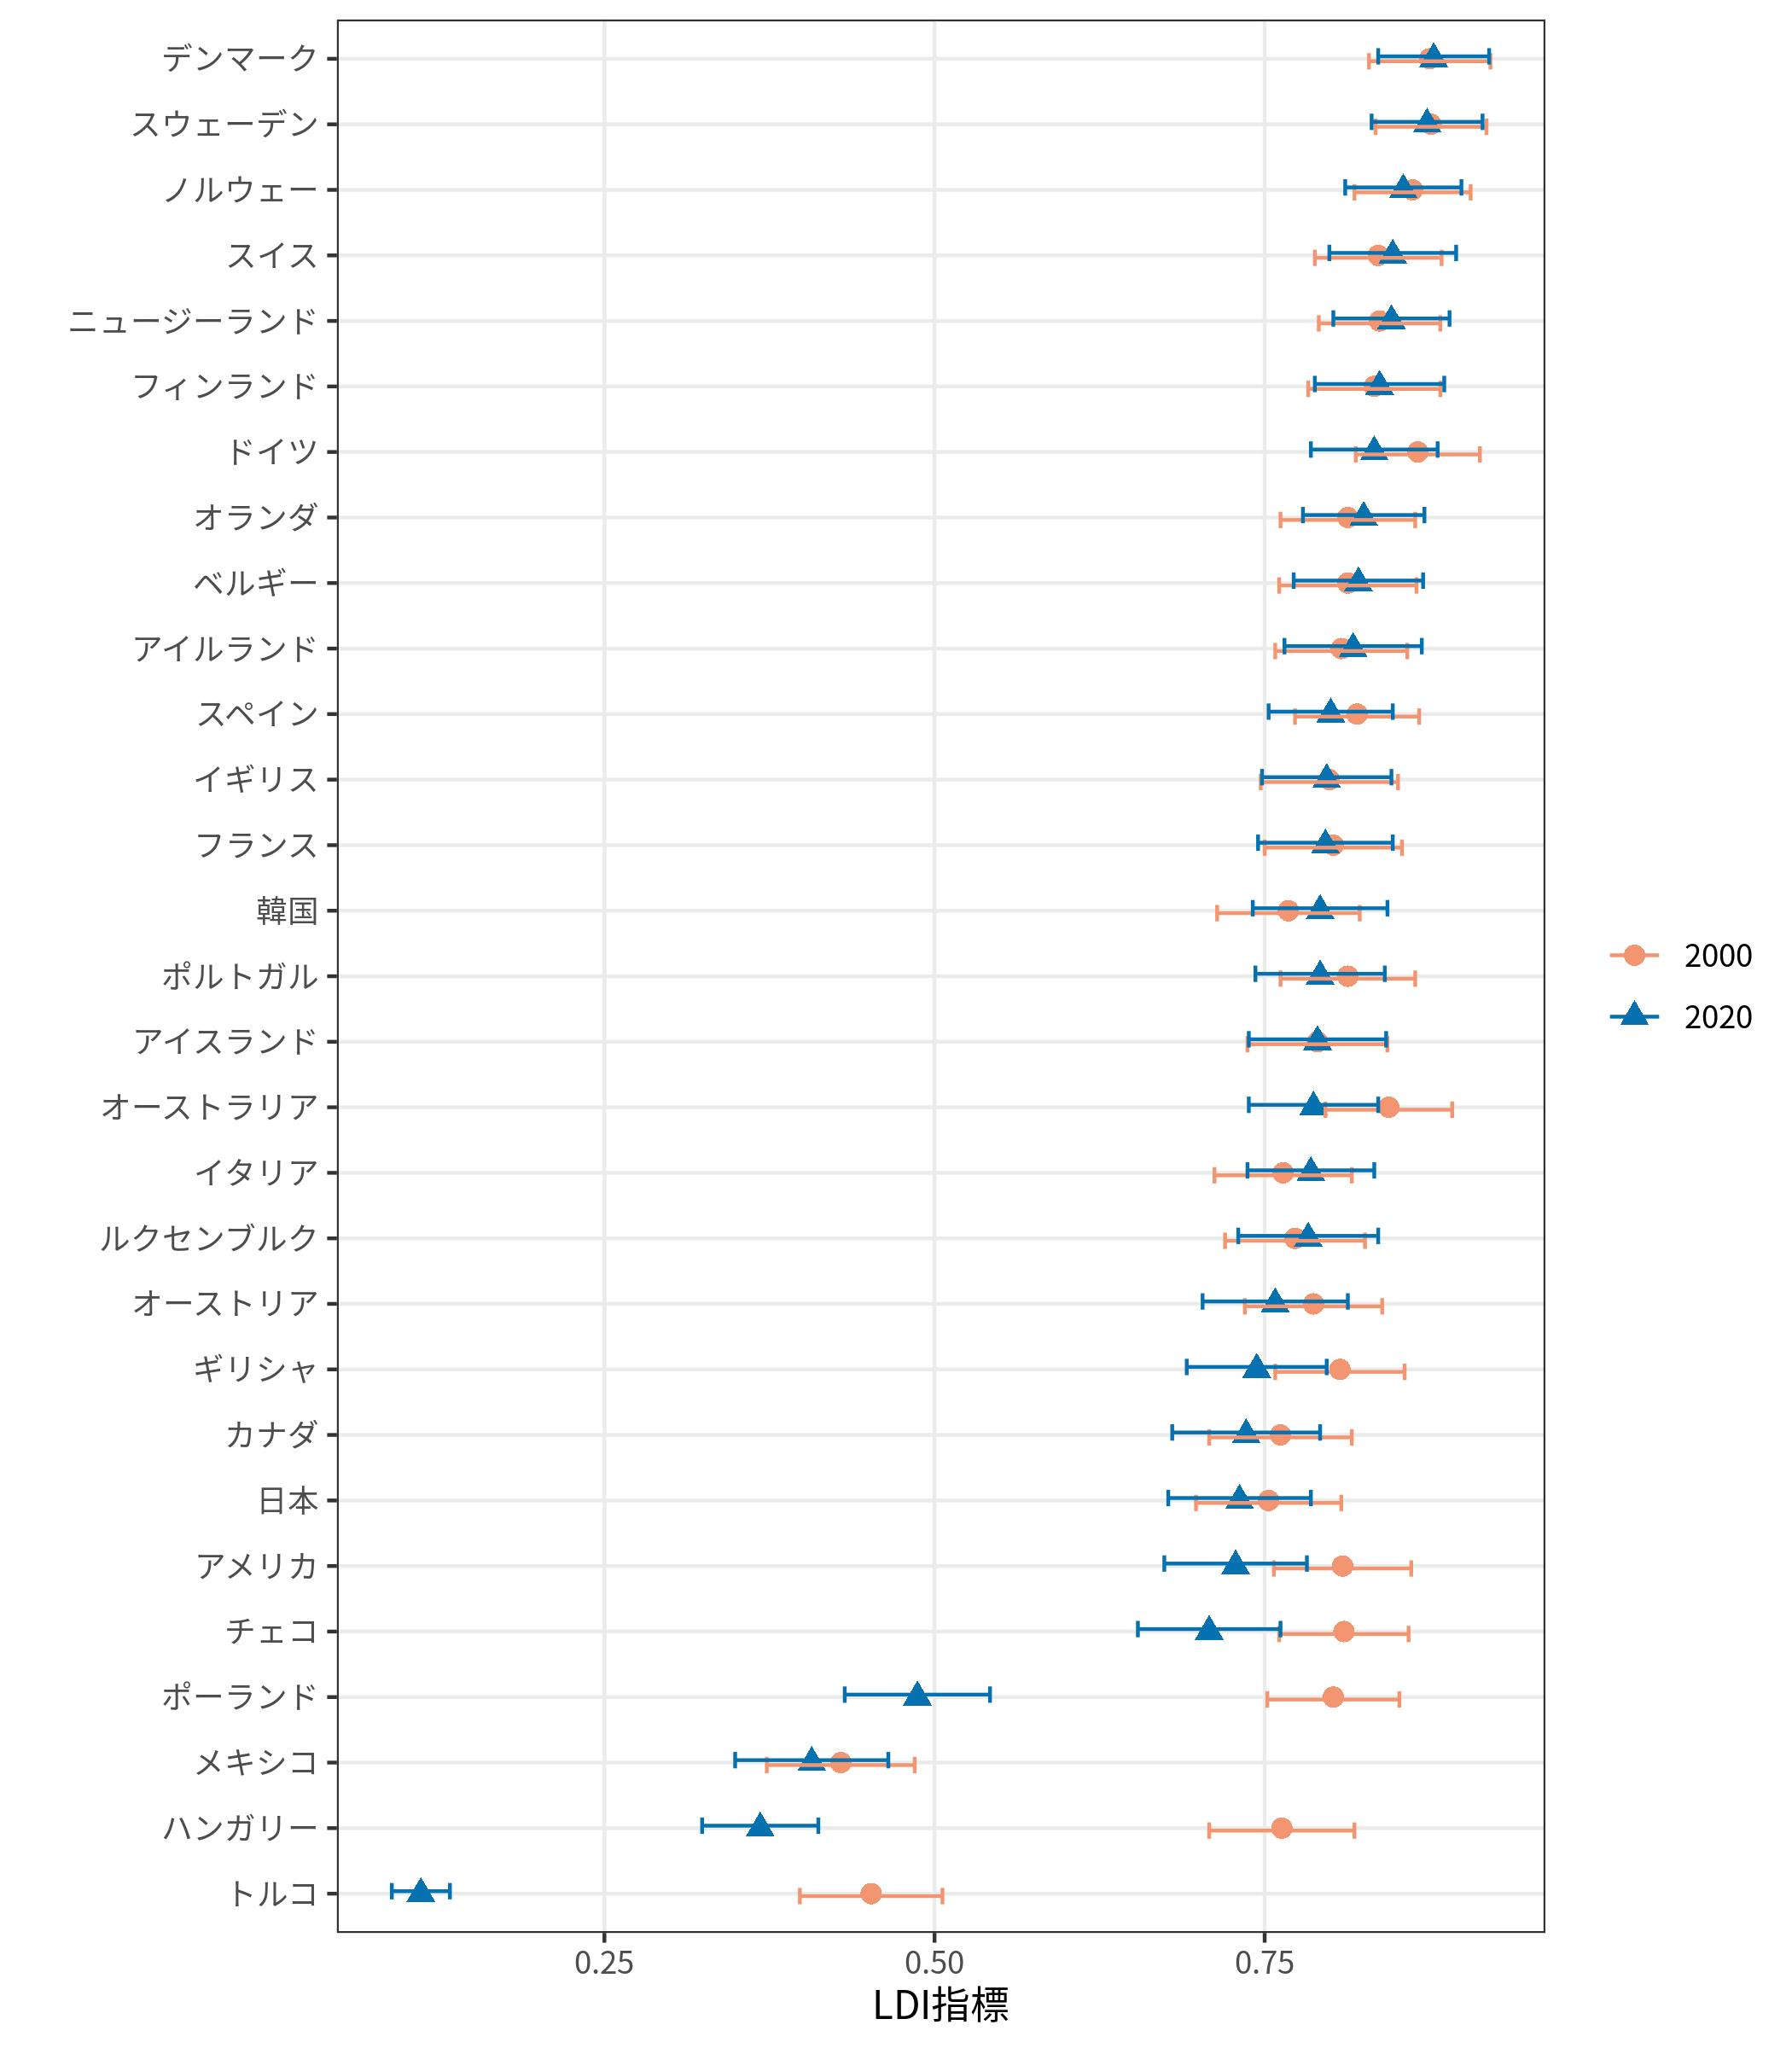

In [9]:
g1 <- ggplot(oecd_data,
             aes(x=v2x_libdem, y=reorder(country_name_jp, order_var),
                   group=factor(year), pch = factor(year), color=factor(year))) + 
  geom_point(size=2.5) +
  labs(x="LDI指標", y="") +
  theme(legend.title=element_blank()) +
  scale_color_manual(values=c("#f49572", "#0571b0")) +
  geom_errorbar(aes(xmin=v2x_libdem-v2x_libdem_sd, xmax=v2x_libdem+v2x_libdem_sd),
                width=0.5, position=position_dodge(0.15))

ggshow(g1, width=7, height=8) 

## Recent trend in liberal democracy index, Japan and OECD average (2000-20)

In [10]:
oecd_data <- vdem_data %>%
  filter(country_name %in% names(OECD_countries), year >= 2000) %>%
  group_by(year) %>%
  summarise(v2x_libdem=mean(v2x_libdem, na.rm=TRUE)) %>%
  ungroup() %>%
  mutate(country_name="OECD", country_name_jp="OECD") 
japan_data <- vdem_data %>%
  filter(country_name == "Japan", year >= 2000) %>%
  select(country_name, year, v2x_libdem) %>%
  mutate(country_name_jp="日本")
    
japan_oecd_data <- rbind(oecd_data, japan_data)
japan_oecd_data

year,v2x_libdem,country_name,country_name_jp
<int>,<dbl>,<chr>,<chr>
2000,0.7850345,OECD,OECD
2001,0.7860000,OECD,OECD
2002,0.7885172,OECD,OECD
2003,0.7912069,OECD,OECD
2004,0.7912069,OECD,OECD
2005,0.7920690,OECD,OECD
2006,0.7937241,OECD,OECD
2007,0.7958966,OECD,OECD
2008,0.7934483,OECD,OECD


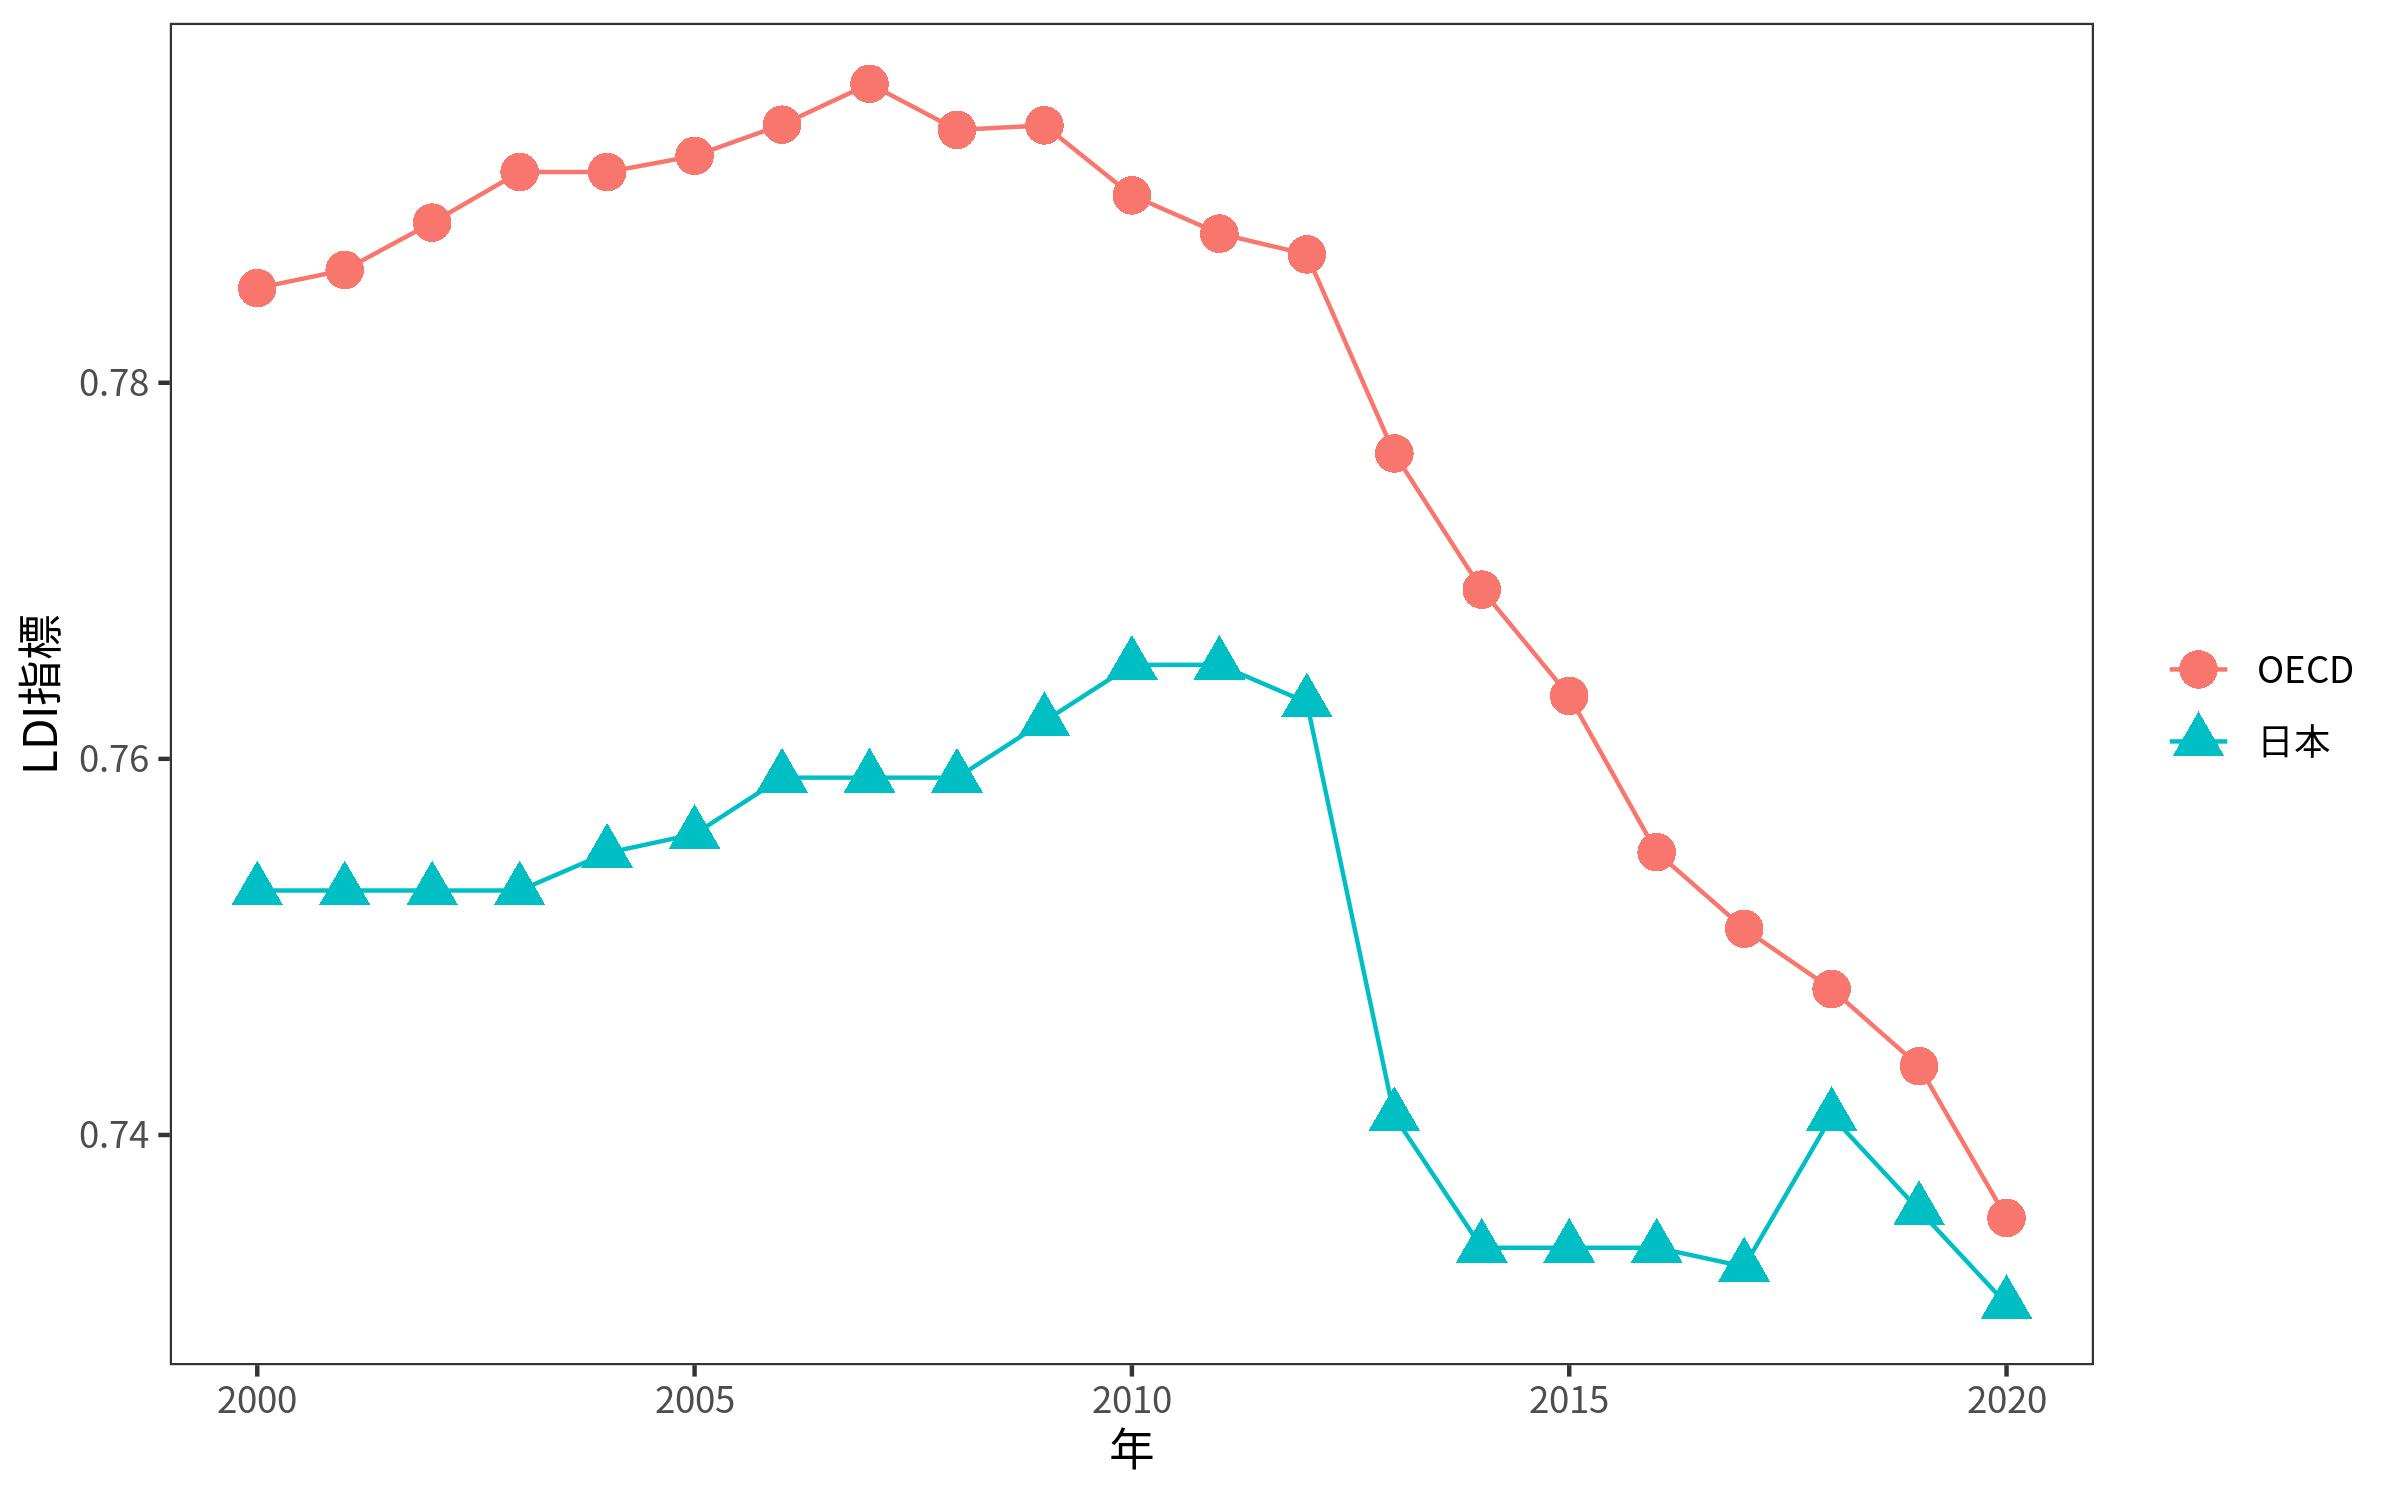

In [11]:
g2 <- ggplot(japan_oecd_data, 
             aes(x=year, y=v2x_libdem, pch=country_name_jp, color=country_name_jp)) + 
  labs(x="年", y="LDI指標") +
  theme(legend.title=element_blank(),
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank()) +
  geom_point(size=4) +
  geom_line()

ggshow(g2, width=8, height=5)

## Components of liberal democracy index in Japan

In [12]:
# Components of liberal democracy index
election_components_jp <- c(
   "v2x_suffr"="選挙権"
  ,"v2xel_frefair"="公正な選挙"
  ,"v2x_frassoc_thick"="結社の自由"
  ,"v2x_elecoff"="被選挙権")

liberal_components_jp <- c( 
   "v2x_freexp_altinf"="表現の自由・複数の情報源"
  ,"v2xcl_rol"="法の下の平等・市民的自由"
  ,"v2x_jucon"="司法による政府監視"
  ,"v2xlg_legcon"="立法府・その他機関による政府監視")

In [13]:
election_component_data <- vdem_data %>%
  filter(country_name == "Japan", year >= 2000) %>%
  `[`(c("country_name", "year", names(election_components_jp))) %>%
  pivot_longer(cols=-c(country_name, year)) %>%
  mutate(var_jp=election_components_jp[name])
election_component_data

country_name,year,name,value,var_jp
<chr>,<int>,<chr>,<dbl>,<chr>
Japan,2000,v2x_suffr,1.000,選挙権
Japan,2000,v2xel_frefair,0.920,公正な選挙
Japan,2000,v2x_frassoc_thick,0.893,結社の自由
Japan,2000,v2x_elecoff,1.000,被選挙権
Japan,2001,v2x_suffr,1.000,選挙権
Japan,2001,v2xel_frefair,0.921,公正な選挙
Japan,2001,v2x_frassoc_thick,0.893,結社の自由
Japan,2001,v2x_elecoff,1.000,被選挙権
Japan,2002,v2x_suffr,1.000,選挙権


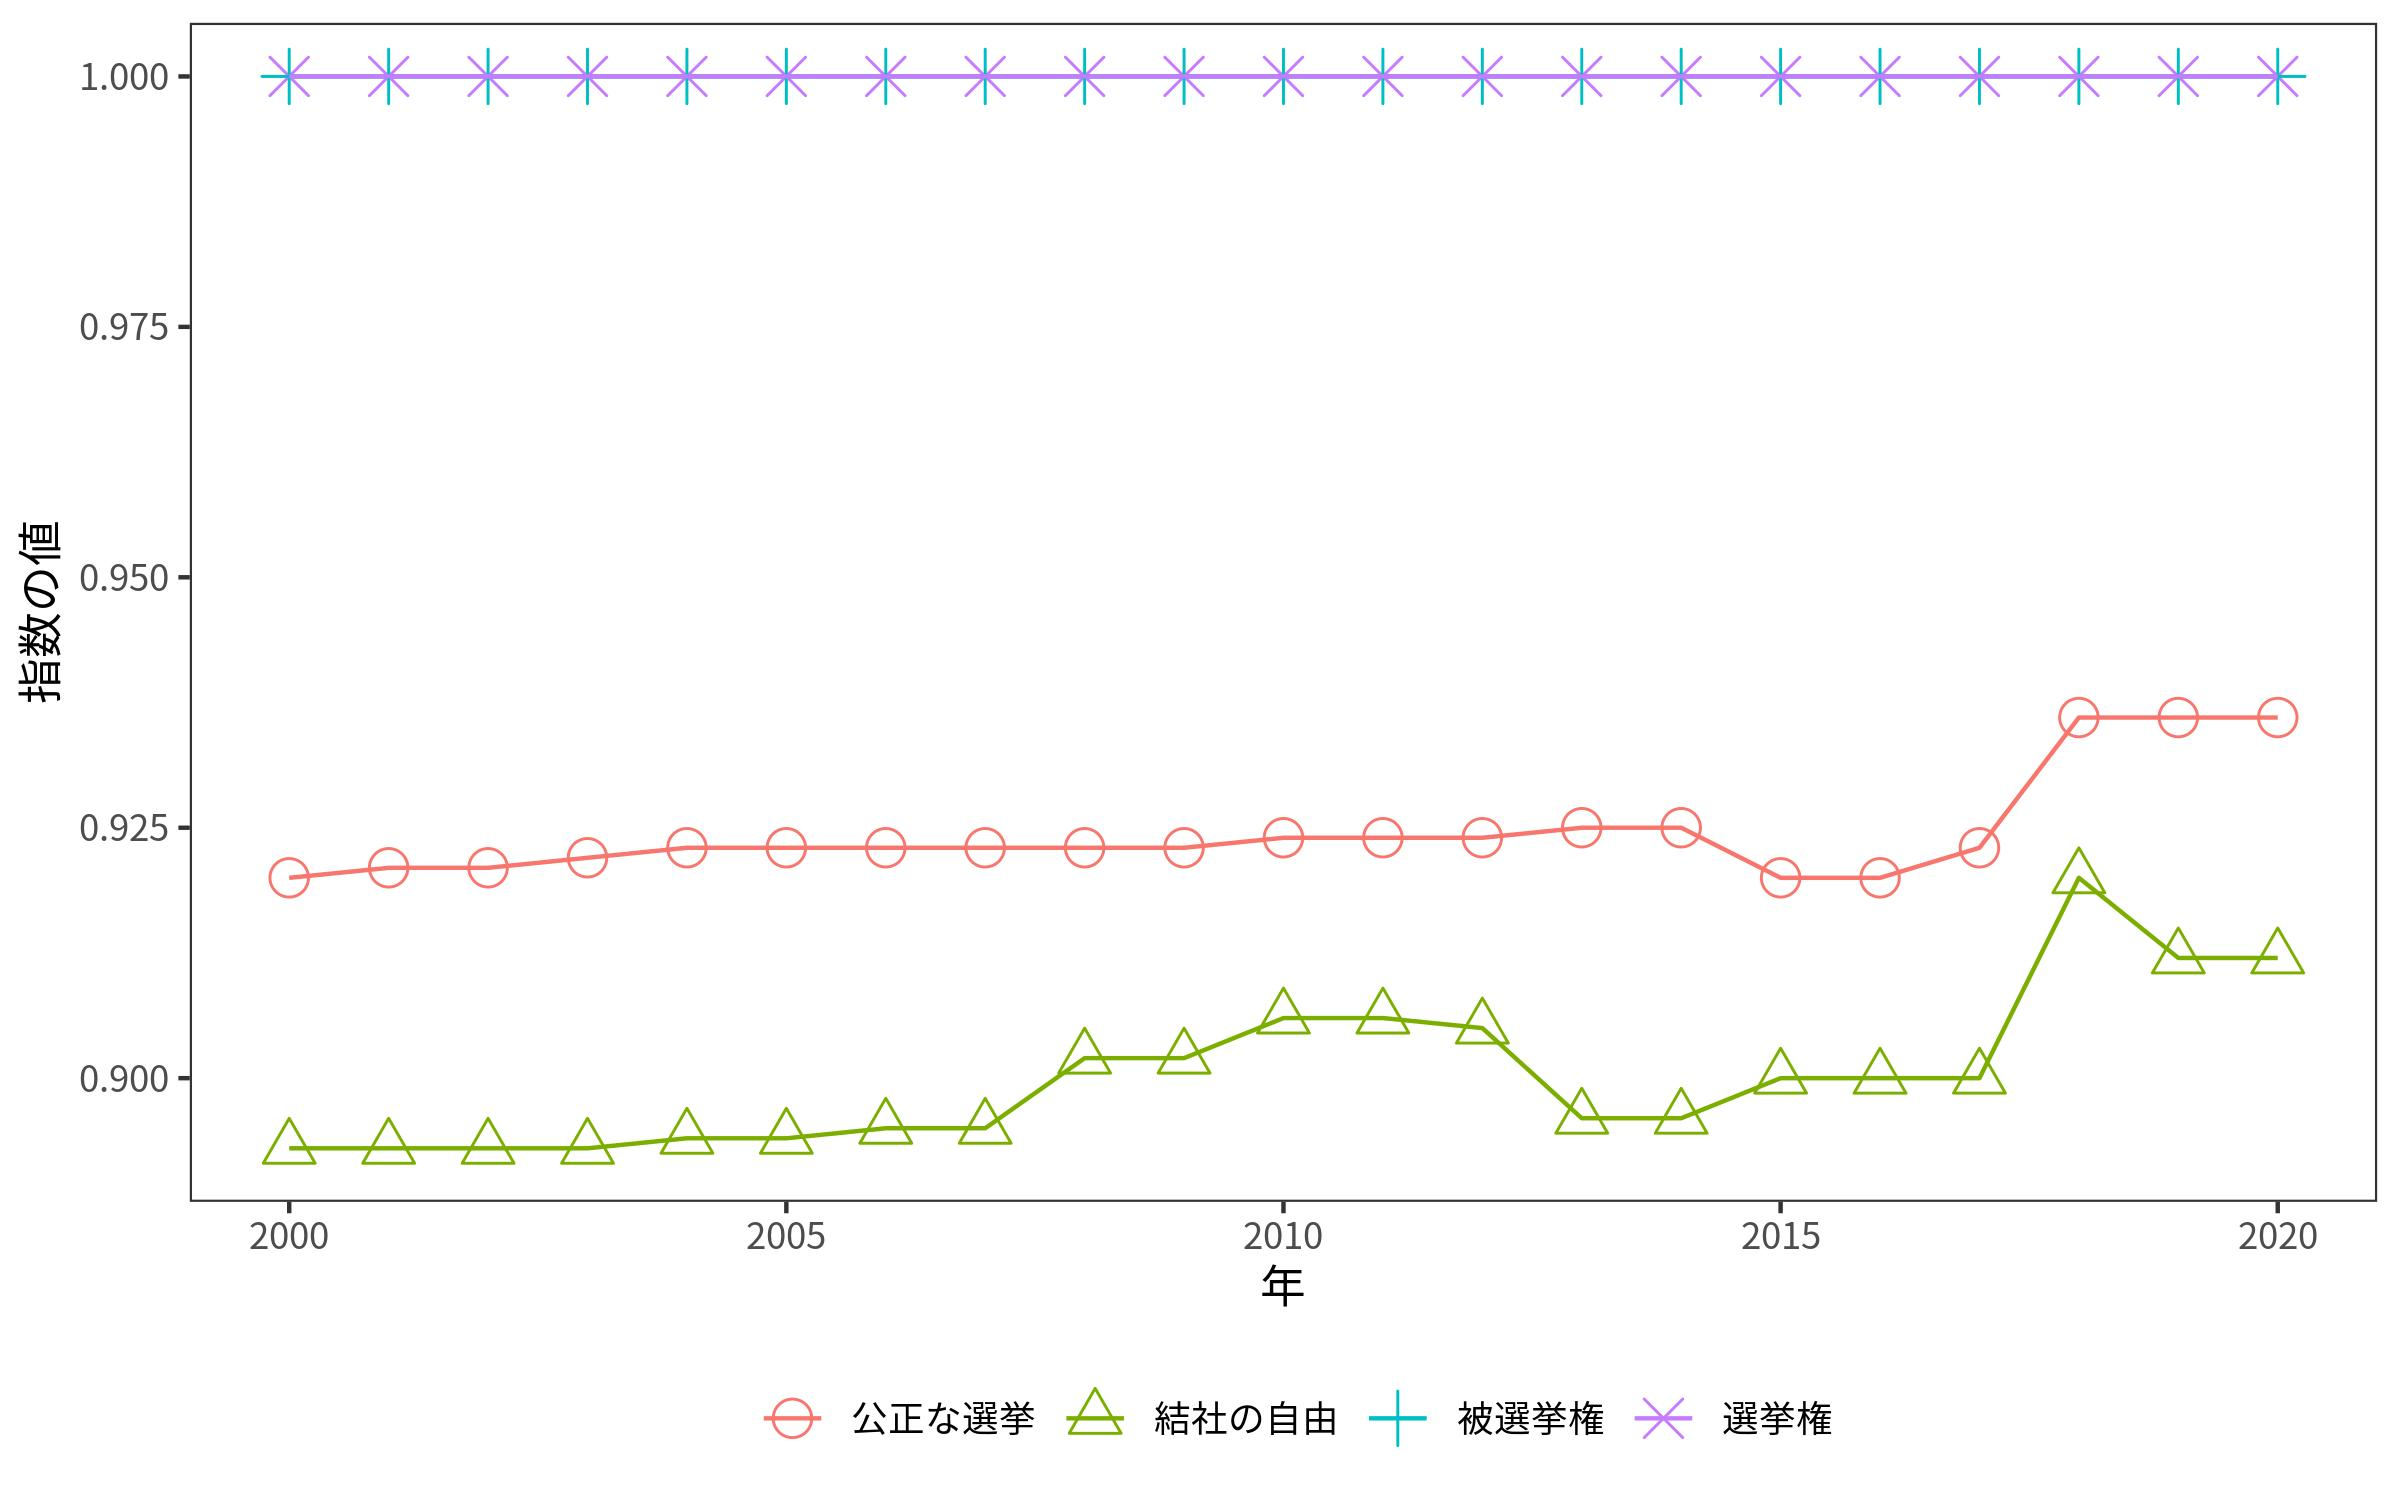

In [14]:
g3a <- ggplot(election_component_data, 
              aes(x=year, y=value, pch=var_jp, color=var_jp)) + 
  labs(x="年", y="指数の値") +
  theme(legend.title=element_blank(),
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank(),
        legend.position="bottom") +
  scale_shape_manual(values=1:4) +
  geom_point(size=4) +
  geom_line()

ggshow(g3a, width=8, height=5)

In [15]:
liberal_component_data <- vdem_data %>%
  filter(country_name == "Japan", year >= 2000) %>%
  `[`(c("country_name", "year", names(liberal_components_jp))) %>%
  pivot_longer(cols=-c(country_name, year)) %>%
  mutate(var_jp=liberal_components_jp[name])
liberal_component_data

country_name,year,name,value,var_jp
<chr>,<int>,<chr>,<dbl>,<chr>
Japan,2000,v2x_freexp_altinf,0.923,表現の自由・複数の情報源
Japan,2000,v2xcl_rol,0.972,法の下の平等・市民的自由
Japan,2000,v2x_jucon,0.849,司法による政府監視
Japan,2000,v2xlg_legcon,0.933,立法府・その他機関による政府監視
Japan,2001,v2x_freexp_altinf,0.923,表現の自由・複数の情報源
Japan,2001,v2xcl_rol,0.972,法の下の平等・市民的自由
Japan,2001,v2x_jucon,0.849,司法による政府監視
Japan,2001,v2xlg_legcon,0.933,立法府・その他機関による政府監視
Japan,2002,v2x_freexp_altinf,0.923,表現の自由・複数の情報源


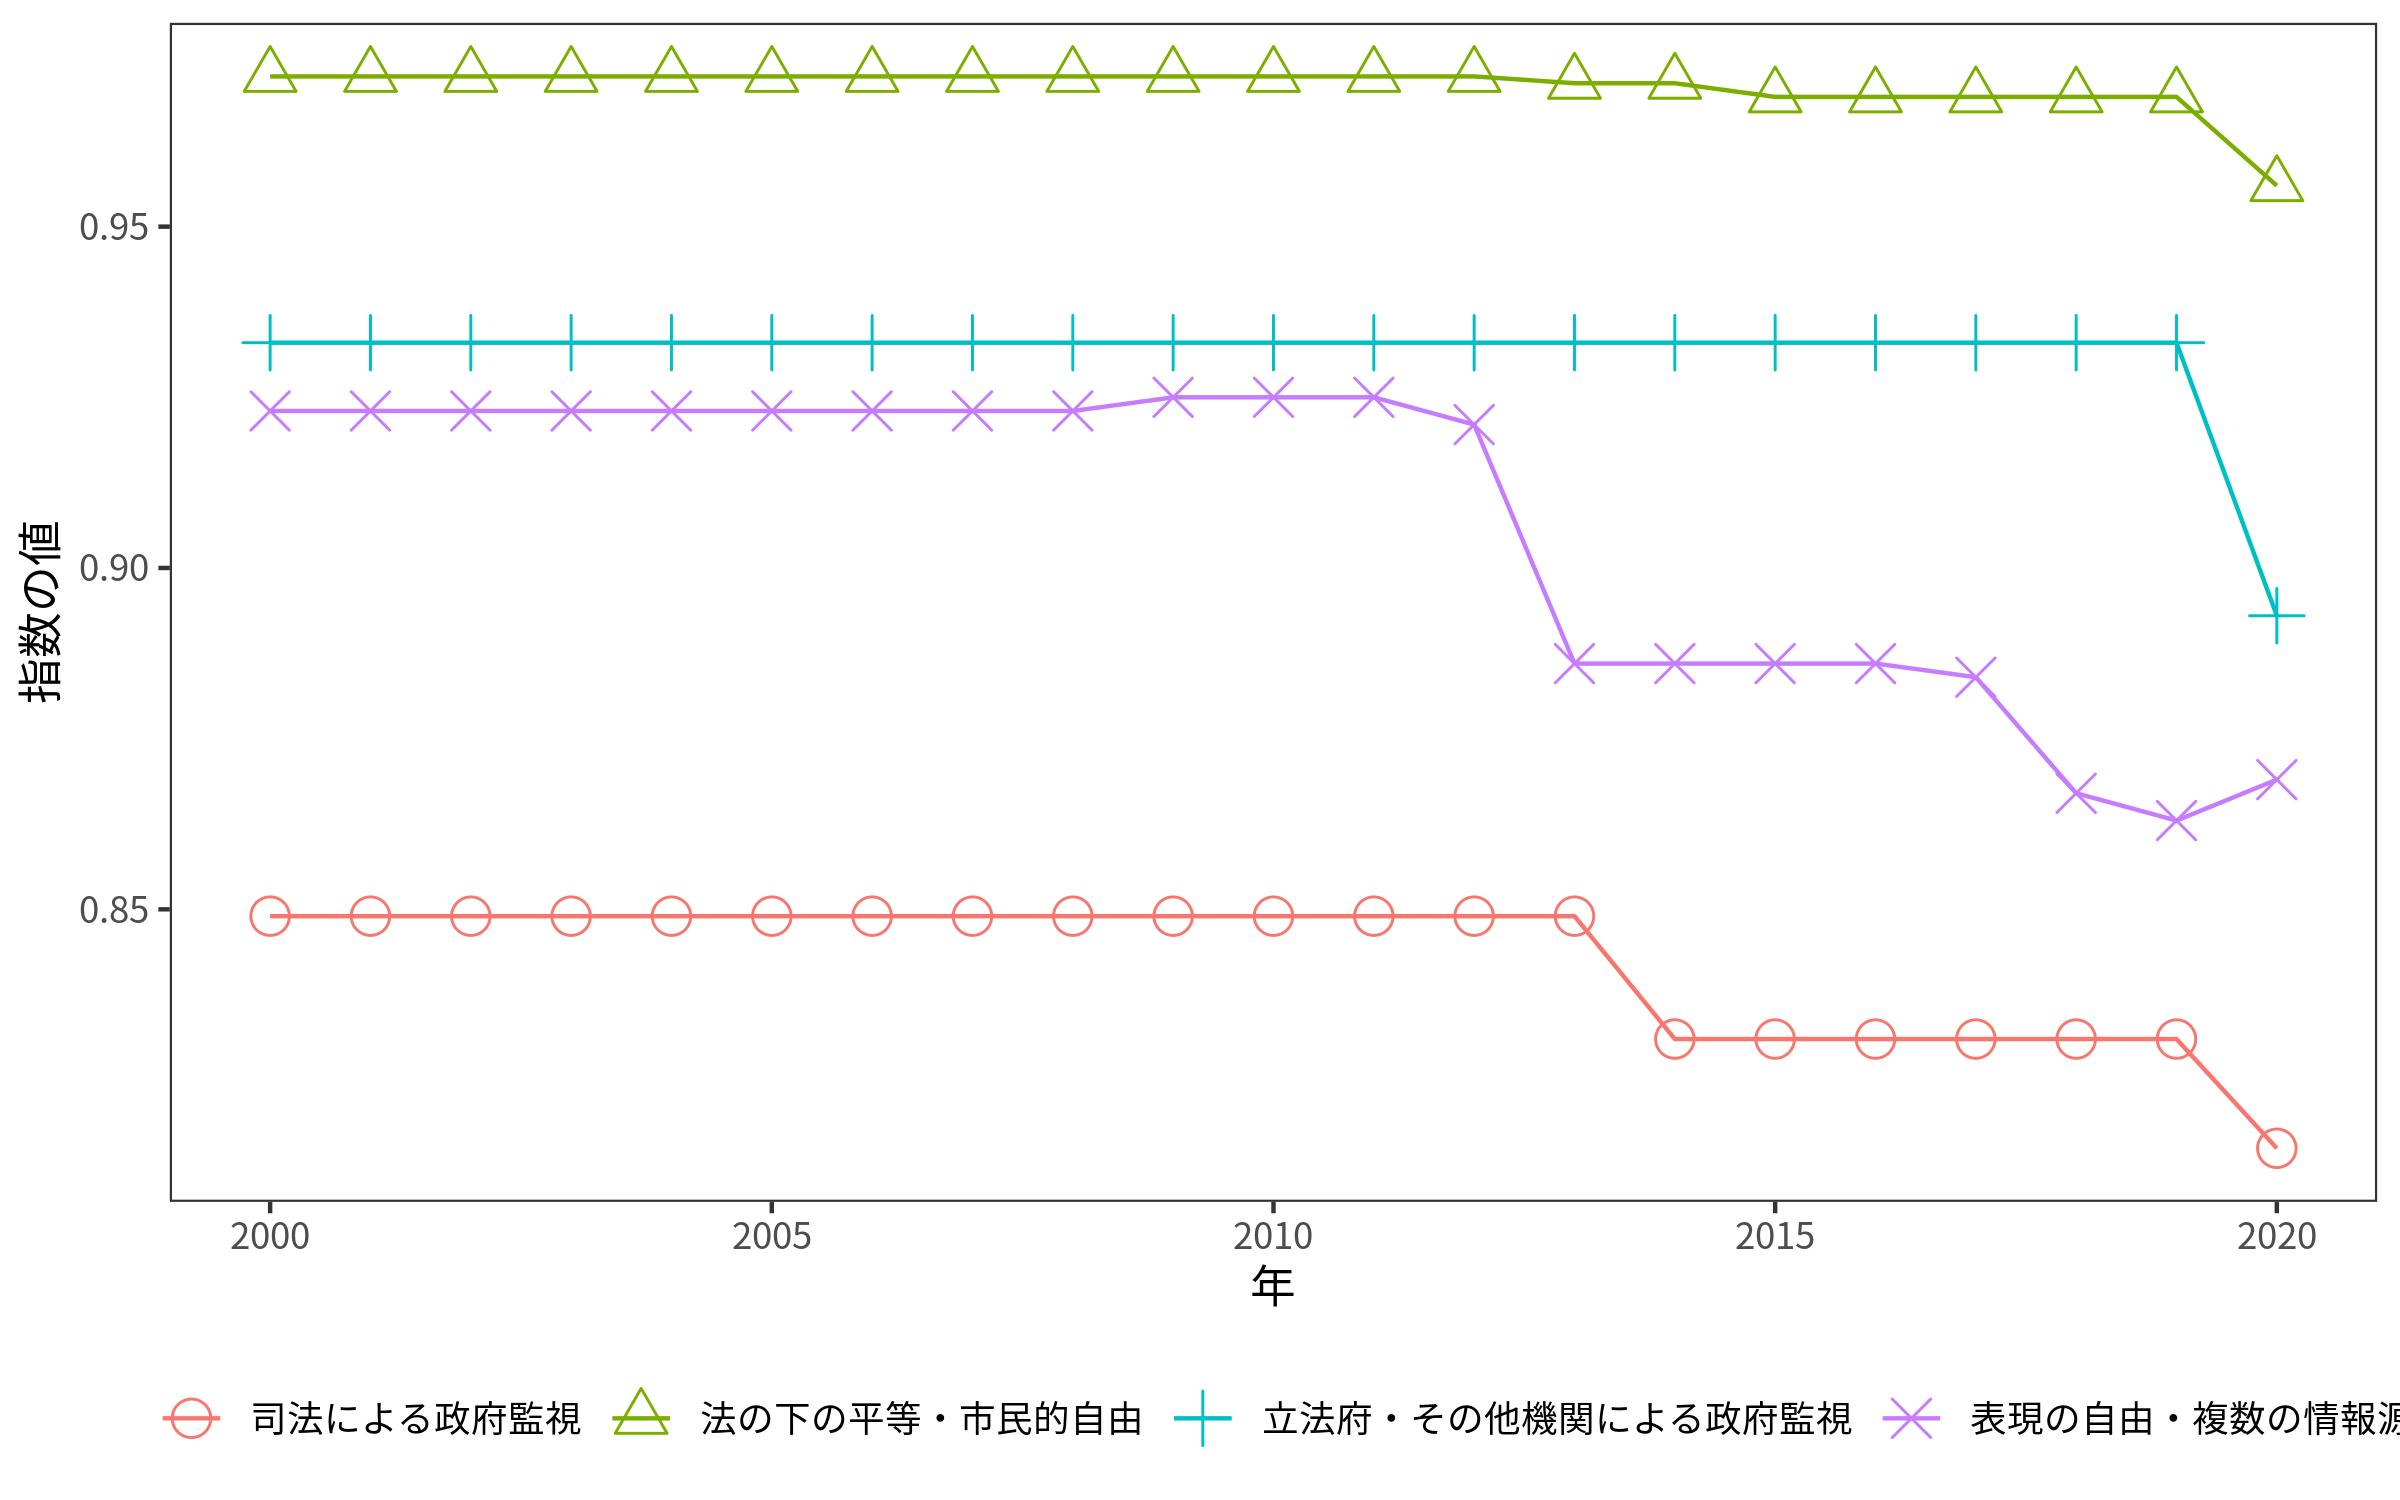

In [16]:
g3b <- ggplot(liberal_component_data, 
              aes(x=year, y=value, pch=var_jp, color=var_jp)) + 
  labs(x="年", y="指数の値") +
  theme(legend.title=element_blank(),
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank(),
        legend.position="bottom") +
  scale_shape_manual(values=1:4) +
  geom_point(size=4) +
  geom_line()

ggshow(g3b, width=8, height=5)